In [1]:
import qutip as qt
from utils import *
import numpy as np
from IPython.display import Math,display

from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qutip import ket2dm

### Acceleration to Stationary State in Quantum Ising Model

$$ H = \Omega S_x - \Delta S_z + \frac{V}{N} S_z^{2}$$ 

The parameters chosen are $\Delta=-1$, $V=3$, $\kappa=1$ (all in units of $\Omega$).

In [2]:
# Pauli Operators
sx = 0.5*qt.operators.sigmax()
sy = 0.5*qt.operators.sigmay()
sz = 0.5*qt.operators.sigmaz()
I =  qt.operators.identity(2)

# jump operators 
sm = qt.operators.sigmam() # spin-lowering operators
kappa = 1
c_ops = kappa*sm

In [29]:
def hamiltonian_ising(N,omega,delta,V):
  sx = 0.5*qt.operators.sigmax()
  #sy = 0.5*qt.operators.sigmay()
  sz = 0.5*qt.operators.sigmaz()
  I = qt.operators.identity(2)

  ising_ham = qt.tensor([I*0]*N)
  for i in range(N):
    hz = qt.tensor([sz if j==i else I for j in range(N)])
    hx = qt.tensor([sx if j==i else I for j in range(N)])
    ising_ham += -1*delta*hz+omega*hx
    for j in range(i + 1, N):
        hzz = qt.tensor([sz if k == i or k == j else I for k in range(N)]) # assume obc
        ising_ham += (V/N)*hzz
  
  return(ising_ham)

In [30]:
# Hamiltonian
omega = np.pi
N = 5
delta = -1*omega
V = 3*omega
hamiltonian=hamiltonian_ising(N,omega,delta,V)

# collapse operator
kappa = 1
c_ops = [qt.tensor([sm if i==j  else I for j in range(N)]) for i in range(N)]
c_ops = [np.sqrt(kappa) * c_op for c_op in c_ops]

In [31]:
# Linbladian
L = qt.liouvillian(hamiltonian, c_ops)
L_dag = qt.liouvillian(hamiltonian, c_ops).dag()

In [32]:
# diagonalization using qutip
val,mat = L_dag.eigenstates()
tol = 1e-8
real_vals = np.where(np.abs(val.imag)<tol,val.real,val)
real_vals = np.where(np.abs(real_vals.real)<tol,real_vals.imag,real_vals)
print('eigen values\n', real_vals)

eigen values
 [-4.52488251+0.j         -4.069693  -7.26504897j -4.069693  -7.26504897j
 ... -0.80651698+4.49220493j -0.73479962+0.j
  0.        +0.j        ]


In [33]:
l2indx = np.argsort(abs(real_vals))[1]
l2 = mat[l2indx].full().reshape(2**N,2**N)

L2 = qt.Qobj(np.round(l2,3))
alphas,phis = L2.eigenstates()

print(alphas)

[-0.06776188  0.02906667  0.04249446  0.04249446  0.04249446  0.04249446
  0.11849191  0.13073343  0.13073343  0.13073343  0.13073343  0.13214113
  0.13214113  0.13214113  0.13214113  0.13214113  0.19926228  0.19994071
  0.19994071  0.19994071  0.19994071  0.20285887  0.20285887  0.20285887
  0.20285887  0.20285887  0.25245196  0.2558314   0.2558314   0.2558314
  0.2558314   0.30048906]


In [34]:
# init_state = qt.tensor([qt.ket('0')]*N)
# init_state

init_state =  qt.rand_ket(2**N)
init_state.dims = [[2]*N,[1]]
init_state

Quantum object: dims = [[2, 2, 2, 2, 2], [1]], shape = (32, 1), type = ket
Qobj data =
[[ 3.99407247e-02-0.00287618j]
 [-5.75906732e-02-0.16405999j]
 [ 1.47209237e-01-0.02580776j]
 [-1.66517270e-01-0.1851282j ]
 [-1.61235918e-01-0.12232859j]
 [-1.90712246e-01+0.10327059j]
 [ 1.76308008e-01+0.17399853j]
 [-1.76302856e-01-0.10964413j]
 [-1.79850207e-01-0.15876948j]
 [-1.41349121e-01-0.17887708j]
 [-3.77235685e-02+0.09067009j]
 [ 1.19715684e-01+0.09339992j]
 [-1.42634939e-01+0.05257025j]
 [-9.35035867e-02+0.07425767j]
 [ 1.61155037e-01-0.07621147j]
 [-1.74879803e-01-0.0363571j ]
 [-5.94031314e-02+0.13879173j]
 [-1.94062020e-01+0.15243015j]
 [ 8.97127699e-03-0.03522952j]
 [-1.69677508e-01+0.13094251j]
 [-5.98692959e-02+0.02171981j]
 [ 6.32694800e-02+0.18730213j]
 [ 1.11707877e-01+0.03339141j]
 [-1.88520750e-01-0.1609537j ]
 [-9.86352304e-05+0.1525881j ]
 [ 1.75767722e-01+0.19177972j]
 [-8.70342981e-02-0.09051794j]
 [ 4.69874558e-03-0.0672451j ]
 [-2.46270131e-02-0.01716856j]
 [-1.86449508e

In [35]:
phi1 = phis[0]
alpha1 = abs(alphas[0])

phi2 = phis[2]
alpha2 = abs(alphas[2])

phi1.dims = init_state.dims
phi2.dims = init_state.dims
s = np.arctan(np.sqrt(alpha1/alpha2))
s

0.9010104782601808

In [36]:
R = phi1*init_state.dag()
R

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[ 0.00050598+3.64364472e-05j -0.00072958+2.07837122e-03j
   0.0018649 +3.26942090e-04j ... -0.00236201+2.00555321e-03j
  -0.00048637-8.80749840e-04j  0.00154317+9.66237313e-04j]
 [-0.00180754-1.55971855e-04j  0.00271443-7.39520855e-03j
  -0.00665227-1.26377317e-03j ...  0.00854829-7.05197640e-03j
   0.00169455+3.17423087e-03j -0.00546934-3.53355946e-03j]
 [-0.00180754-1.55971855e-04j  0.00271443-7.39520855e-03j
  -0.00665227-1.26377317e-03j ...  0.00854829-7.05197640e-03j
   0.00169455+3.17423087e-03j -0.00546934-3.53355946e-03j]
 ...
 [ 0.01024808+5.13616501e-03j -0.0332038 +3.70800512e-02j
   0.03610533+2.29521515e-02j ... -0.06665353+2.14434025e-02j
  -0.00253734-2.25928331e-02j  0.02386049+3.35162567e-02j]
 [ 0.01024808+5.13616501e-03j -0.0332038 +3.70800512e-02j
   0.03610533+2.29521515e-02j ... -0.06665353+2.14434025e-02j
  -0.00253734-2.25928331e-02j  0.02386049+

In [37]:
arg =(-s*1j)*(phi1*phi2.dag()+phi2*phi1.dag())
Us = arg.expm()
R.dims = Us.dims
U = Us*R
U

Quantum object: dims = [[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[ 3.14123745e-04+2.26204065e-05j -4.52936146e-04+1.29029051e-03j
   1.15776359e-03+2.02971572e-04j ... -1.46637844e-03+1.24508377e-03j
  -3.01945493e-04-5.46785456e-04j  9.58029810e-04+5.99857629e-04j]
 [-1.02319173e-03+3.00230131e-04j -9.12301250e-05-4.62918203e-03j
  -3.91279911e-03+7.27184078e-04j ...  3.17695624e-03-5.68589442e-03j
   1.60527345e-03+1.37685002e-03j -3.74922953e-03-7.68266828e-04j]
 [-1.44882105e-03+5.67196150e-05j  1.41430646e-03-6.13478807e-03j
  -5.40091144e-03-3.38181278e-04j ...  6.07440258e-03-6.44485330e-03j
   1.66045146e-03+2.34782621e-03j -4.68945629e-03-2.25602134e-03j]
 ...
 [ 3.04916198e-03+3.14966256e-03j -1.66727727e-02+9.18381271e-03j
   1.01284250e-02+1.28495499e-02j ... -2.67678564e-02-6.89649858e-04j
   1.94128154e-03-8.47492895e-03j  4.37318031e-03+1.51138227e-02j]
 [ 5.59057364e-03+6.86469012e-03j -3.51353152e-02+1.55956785e-02j


In [43]:
def u(phi,theta,lamda):
    u = ((1j/2)*phi*sz).expm()*((1j/2)*theta*sy).expm()*((1j/2)*lamda*sz).expm()
    return(u)

def Us(params):
    phi,theta,lamda = params[:N], params[N:2*N],params[2*N:3*N]
    gates = []
    for i in range(N):
        gates.append(u(phi[i],theta[i],lamda[i]))
    U_s = qt.tensor(gates)
    return U_s


def chi(params):
    U_s = Us(params)
    Udag = U_s.dag()
    rho_0 = ket2dm(init_state)
    L2.dims = U_s.dims
    c = abs((L2*U_s*rho_0*Udag).tr())
    return c

epsilon = 1e-4
def cost(params):
    c = chi(params)
    return abs(c-epsilon)

In [39]:
def u(phi,theta):
    u = ((1j/2)*phi*sz).expm()*((1j/2)*theta*sy).expm()
    return(u)

def Us(params):
    phi,theta = params[:N], params[N:2*N]
    gates = []
    for i in range(N):
        gates.append(u(phi[i],theta[i]))
    U_s = qt.tensor(gates)
    return U_s


def chi(params):
    U_s = Us(params)
    Udag = U_s.dag()
    rho_0 = ket2dm(init_state)
    L2.dims = U_s.dims
    c = abs((L2*U_s*rho_0*Udag).tr())
    return c

epsilon = 1e-4
def cost(params):
    c = chi(params)
    return abs(c-epsilon)

In [44]:
initial_guess = np.concatenate([np.random.uniform(0, np.pi,N), np.random.uniform(0, 2*np.pi-0.001,N),np.random.uniform(0, np.pi,N)])

bounds = [(0, np.pi)] * N + [(0, 2 * np.pi - 0.001)] * N + [(0, 2*np.pi)] * N

# Perform optimization
result = minimize(
    cost,                 # Objective function
    initial_guess,       # Initial  # Constraints
    bounds=bounds,
    method='SLSQP',
    options={'disp': True},
    tol = 1e-16
)

Uspin = Us(result.x)

Iteration limit reached    (Exit mode 9)
            Current function value: 0.1051922961321366
            Iterations: 100
            Function evaluations: 1600
            Gradient evaluations: 100


In [45]:
# solving master equation
final_state = qt.steadystate(hamiltonian,c_ops) # steady state solution 

tlist = omega*np.linspace(0, 4, 5000)
medata = qt.mesolve(hamiltonian, init_state, tlist, c_ops, []) # initial state  = |0>
qmpedata = qt.mesolve(hamiltonian, U*init_state, tlist, c_ops, []) # Mpemba unitary rotated state
gspindata = qt.mesolve(hamiltonian, Uspin*init_state, tlist, c_ops, [])

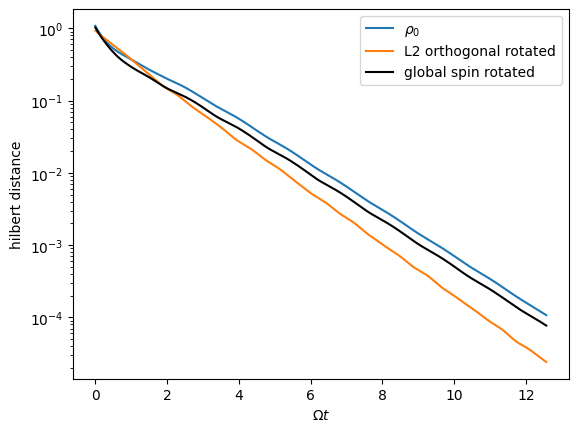

In [46]:
# calculation of Hilbert Distances

hilbert_distance = []
qmpe_dist = []
gspin_dist = []

for state in medata.states:
  dis = (np.trace((state-final_state)**2))**(1/2)
  hilbert_distance.append(dis)

for state in qmpedata.states:
  dis = (np.trace((state-final_state)**2))**(1/2)
  qmpe_dist.append(dis)

for state in gspindata.states:
  dis = (np.trace((state-final_state)**2))**(1/2)
  gspin_dist.append(dis)

plt.yscale('log')
plt.plot(tlist,hilbert_distance,label=r'$\rho_0$')
plt.plot(tlist,qmpe_dist,label=r'L2 orthogonal rotated')
plt.plot(tlist,gspin_dist,color='black',label='global spin rotated')
plt.xlabel(f'$\Omega t$')
plt.ylabel('hilbert distance')
plt.legend()
plt.show()